In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Importar dataset

In [2]:
dataset_path = '../data/dogs'
im_size = (150, 150)
batch_size = 32
n_labels = 120

im_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
    )

train_generator = im_generator.flow_from_directory(
    dataset_path,
    target_size=im_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=1425
)

val_generator = im_generator.flow_from_directory(
    dataset_path,
    target_size=im_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=1425
)


Found 8745 images belonging to 120 classes.
Found 1477 images belonging to 120 classes.


## Visualizar ejemplos

Found 10222 images belonging to 120 classes.


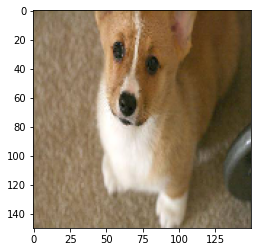

pembroke


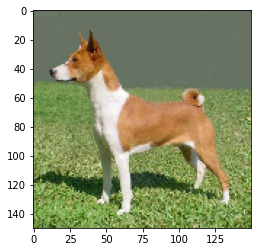

basenji


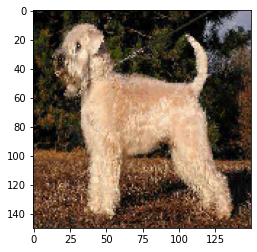

lakeland_terrier


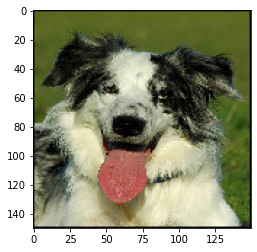

border_collie


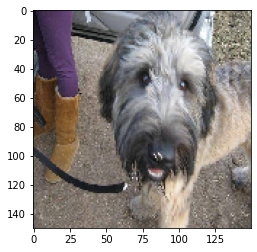

briard


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(dataset_path, batch_size=10,target_size=im_size)
classes = {value: key for key, value in test_batches.class_indices.items()}
# print(classes)
x_batch, y_batch = next(test_batches)
for i in range (5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()
    print(classes[np.argmax(y_batch[i])])

## Inception


In [4]:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


--2020-11-14 12:40:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.192.128, 2800:3f0:4003:c02::80, 2800:3f0:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83,84M  6,63MB/s    in 13s     

2020-11-14 12:40:44 (6,47 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [5]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()



In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (n_labels, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=im_size + (3,), num_classes=120)
# keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 75, 75, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 75, 75, 32)   128         conv2d_94[0][0]                  
____________________________________________________________________________________________

## Entrenamiento


In [10]:
callbacks = [
     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", monitor='val_loss', save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [11]:
epochs = 50
callbacks = [
     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", monitor='val_loss', save_best_only=True),
]
history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks, validation_data=val_generator,
)

Epoch 1/50
  3/274 [..............................] - ETA: 6:39 - loss: 5.2464 - accuracy: 0.0104    

KeyboardInterrupt: 